# 2-Asset-HANK Tutorial

The package supports heterogeneous agent models with and without porfolio chocie (i.e., with one asset and two assets, respectively). Both examples are keept relatively close to the ones used in the [Sequence-Space Jacobian package](https://github.com/shade-econ/sequence-jacobian) for reasons of comparability. 

While for models without heterogenous agents, the calculation of the sequence-space jacobian for the nonlinear extended path is already speed and memmory optimized, this is not yet the case for HANK (but would be relatively straightforward). 

Start with some misc imports and load the package:

In [2]:
import jax.numpy as jnp # use jax.numpy instead of normal numpy. Yes, this is one of the reasons why it is nice not to have all numpy objects imported on the lowest hirarchy
from grgrlib import figurator, grplot # a nice backend for batch plotting with matplotlib
import econpizza as ep # pizza
import matplotlib.pyplot as plt

# for nicer text in figures
plt.rc('text', usetex=True)
# only necessary if you run this in a jupyter notebook:
%matplotlib inline 

This second example is the two-asset HANK model from [Auclert et al., 2022](http://mattrognlie.com/sequence_space_jacobian.pdf), which is documented [here](https://github.com/shade-econ/sequence-jacobian/blob/master/notebooks/two_asset.ipynb).

There are, again, some deviations. First, the NK-Phillips Curve is the conventional nonlinear Phillips Curve as derived from Rothemberg pricing,

$$
     \psi\left(\frac{\pi_t}{\pi_{SS}} - 1\right)\frac{\pi_t}{\pi_{SS}} = (1-\theta) + \theta \widehat{MC}_t + E_t\left\{ \psi \frac{\pi_{t+1}}{R_t}\left(\frac{\pi_{t+1}}{\pi_{SS}} - 1\right) \frac{\pi_{t+1}}{\pi_{SS}}\frac{Y^p_{t+1}}{Y^p_t}\right\},
$$
 
 which also features the inverse real rate $\frac{\pi_{t+1}}{R_t}$.
 
Importantly, the wage Phillips Curve is modified in a similar fashion. 
 
Further, the central bank sets the nominal interest rate to follow a conventional monetary policy rule with interest rate inertia,
$$
    R_{s,t} = \left[R^*\left(\frac{\pi_t}{\pi_{SS}}\right)^{\phi_\pi} \left(\frac{Y_t}{Y_{t-1}}\right)^{\phi_y}\right]^{1-\rho} R_{s,t-1}^\rho.
$$

Finally, capital adjustment costs are defined as in the Smets & Wouters Model (but without capital utilization):
$$
\begin{align}
    E_t R_{t+1} q_t 
    &= \alpha E_t \left\{Z_{t+1} \left(\frac{N_{t+1}}{K_t}\right)^{1-\alpha} \widehat{MC}_{t+1}\right\}
    + (1-\delta) E_t q_{t+1},\\
    1 &= q_t \left[1-S\left(\frac{I_t}{I_{t-1}}\right) - 
        S' 
        \left(
        \frac{I_t}{I_{t-1}} \right)
        \frac{I_t}{I_{t-1}}\right] + 
        E_t 
        \left\{ 
            \frac{q_{t+1}}{R_{t+1}}
    S'\left( \frac{I_{t+1}}{I_t} \right) \left(\frac{I_{t+1}}{I_t}\right)^2 \right\}.
\end{align}
$$

The `yaml` file of the model can be found [here](https://github.com/gboehl/econpizza/blob/master/econpizza/examples/hank2.yaml). Let's quickly run this model in a similar fashion as above.

In [3]:
from econpizza import example_hank2
# parse model
hank2_dict = ep.parse(example_hank2)
# compile the model
hank2 = ep.load(hank2_dict)

ImportError: cannot import name 'example_hank2' from 'econpizza' (/home/gboehl/github/econpizza/econpizza/__init__.py)

In [20]:
stst_result = hank2.solve_stst()

    Iteration   1 | max error 1.19e+01 | lapsed 7.2663
    Iteration   2 | max error 4.82e-01 | lapsed 7.9043
    Iteration   3 | max error 1.35e-02 | lapsed 8.4808
    Iteration   4 | max error 7.42e-04 | lapsed 9.0556
    Iteration   5 | max error 3.63e-08 | lapsed 9.6322
(solve_stst:) Steady state found (11.959s). The solution converged.


Again, look at a discount factor shock and calculate the pefect foresight solution:

In [21]:
# this is a dict containing the steady state values
x0 = hank2['stst'].copy()
# setting a shock on the discount factor
x0['beta'] *= 1.01

But let us this time start with a *linear* IRFs, just because we can:

In [22]:
xlin, flags = hank2.find_path_linear(x0=x0.values())

(get_derivatives:) Derivatives calculation done (8.624s).
(get_jacobian:) Jacobian accumulation and decomposition done (8.329s).
(find_path_linear:) Linear solution done (22.567s).


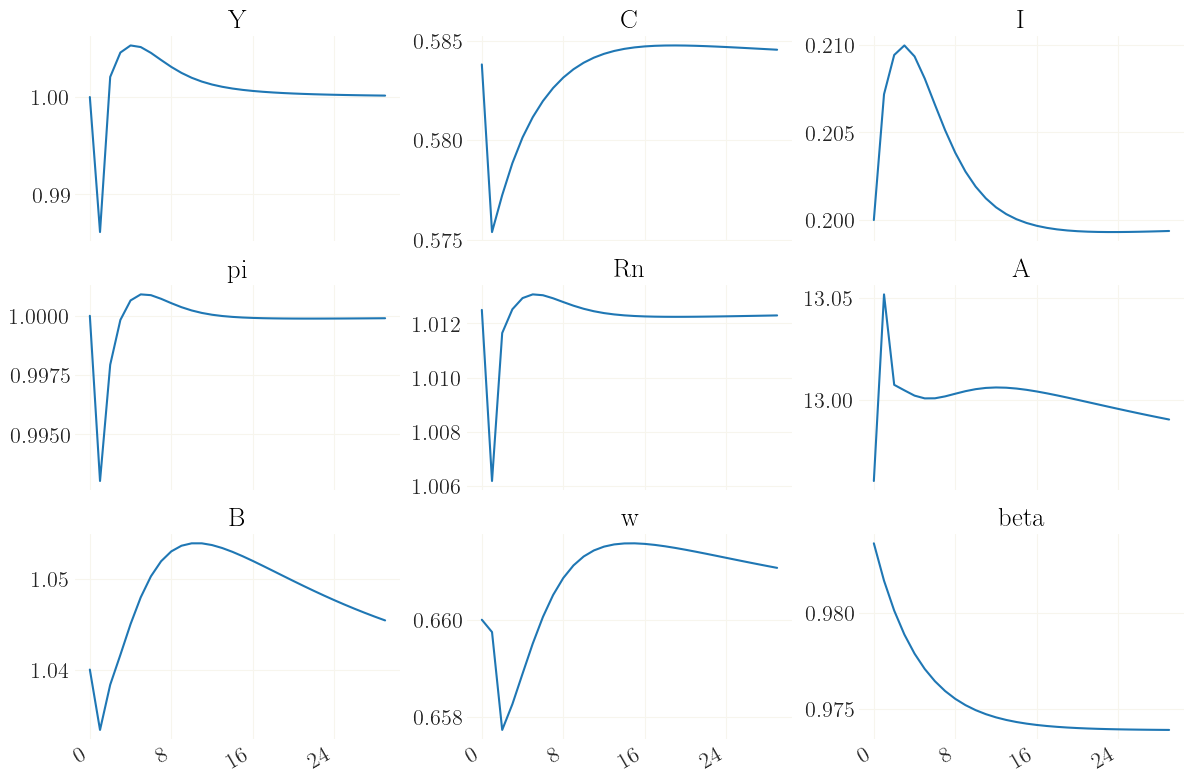

In [23]:
variables = 'Y', 'C', 'I', 'pi', 'Rn', 'A', 'B', 'w', 'beta'
inds = [hank2['variables'].index(v) for v in variables] 

figs, axs = figurator(3,3, figsize=(12,8))
_ = grplot(xlin[:30, inds], labels=variables, ax=axs)

Great. Finally, we can compare this with the fully nonlinear responses:

In [24]:
xst, flags = hank2.find_path(x0=x0.values())

    Iteration   8 | max error 1.35e-09 | dampening 0.339 | lapsed 9.5751s
(find_path:) Stacking done (9.625s). The solution converged.


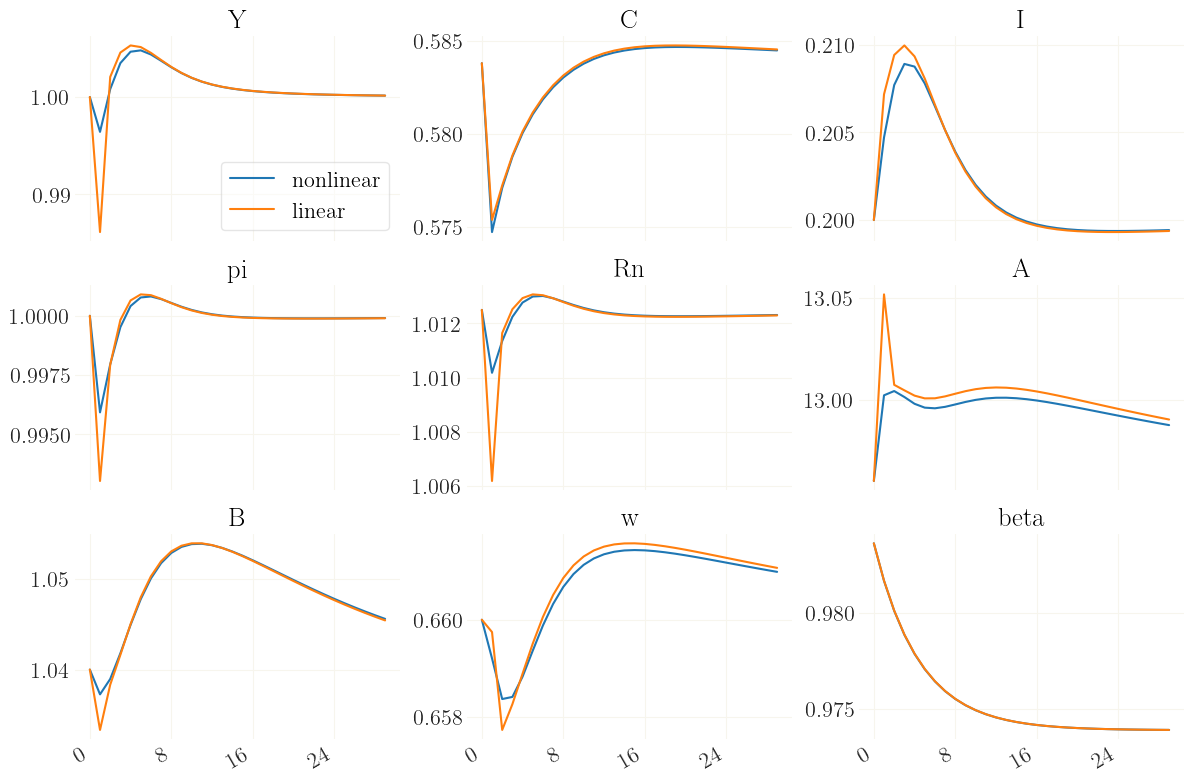

In [25]:
figs, axs = figurator(3,3, figsize=(12,8))
_ = grplot((xst[:30, inds], xlin[:30, inds]), labels=variables, ax=axs, legend=('nonlinear', 'linear'))
_ = axs[0].legend(fontsize=16)

Surprisingly, there is quite some difference between the linear and nonlinear solution.


This ends this short tutorial. Further details on the implementation of heterogeneous agent models are given [in the technical section](https://econpizza.readthedocs.io/en/latest/method.html).